In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
from tensorflow.keras.optimizers import Adam

# Data preparation

In [2]:
data_path = "/Users/wilkie/data/smart_pixels_13/resampled/"

In [3]:
pq1 = pd.read_parquet(data_path + "pixels.parquet")

In [4]:
def take_yprofile(data):
    data = np.array(data)
    #reshape to 2D
    data = np.reshape(data, (13, 21))
    #take the y-profile
    profile = np.sum(data, axis=1)
    return profile


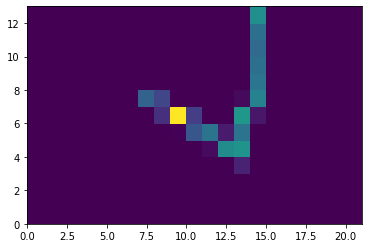

In [6]:
arr = np.array(pq1.iloc[5])
plt.pcolor(np.reshape(arr, (13, 21)))

In [7]:
prof = take_yprofile(pq1.iloc[0])

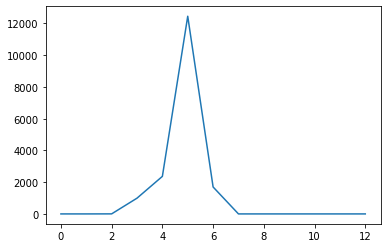

In [8]:
plt.plot(prof)

In [9]:
pq1_truth = pd.read_parquet(data_path + "momenta.parquet")

In [10]:
pq1_truth

,pt
0,-1.2465
1,0.3375
2,-0.1155
3,-0.7995
4,1.0245
...,...
142815,-0.8895
142816,-1.0505
142817,1.1725
142818,1.8035


In [15]:
X_train = pq1.values[0:80000,:]

In [16]:
X_train.shape

(80000, 273)

In [18]:
y_pt_train = pq1_truth.values[0:80000,:]

In [19]:
y_pt_train.shape

(80000, 1)

In [17]:
#original is 652,160 samples

In [20]:
X_test = pq1.values[80000:,:]

In [23]:
y_pt_test = pq1_truth.values[80000:,:]

In [24]:
y_pt_test.shape

(62820, 1)

In [25]:
def get_truth(momenta, threshold):
    return 1.0 * (momenta > threshold) + 2.0 * (momenta < -1 * threshold)

In [38]:
threshold = 0.2

In [39]:
y_train = get_truth(y_pt_train, threshold)

In [40]:
y_test = get_truth(y_pt_test, threshold)

(array([ 8270.,     0.,     0.,     0.,     0., 35881.,     0.,     0.,
            0., 35849.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

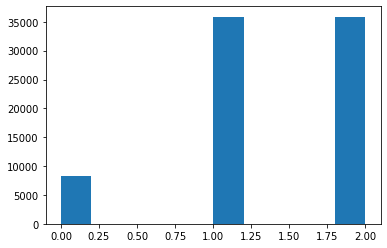

In [41]:
plt.hist(y_train)

In [42]:
#original is 3,597,877 test samples

# Training

In [43]:
# X_train = df1.values
# X_test = df3.values

# y_train = df2.values
# y_test = df4.values
# #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80000, 273) (62820, 273) (80000, 1) (62820, 1)


In [44]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [45]:
#X_test_huge = scaler.transform(X_test_huge.reshape(-1, X_test_huge.shape[-1])).reshape(X_test_huge.shape)

In [63]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(273,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1,)
])

model.compile(optimizer=Adam(),
              loss="mse",
              metrics=[keras.metrics.RootMeanSquaredError()])

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 273)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               35072     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 35,201
Trainable params: 35,201
Non-trainable params: 0
_________________________________________________________________


In [64]:
es = EarlyStopping(monitor=model.loss, 
                                   mode='min', 
                                   patience=20,
                                   restore_best_weights=True)

history = model.fit(X_train,
                    y_pt_train,
                    callbacks=[es],
                    epochs=200, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)



Epoch 1/200
63/63 [==============================] - 1s 10ms/step - loss: 1.7236 - root_mean_squared_error: 1.3128 - val_loss: 1.6708 - val_root_mean_squared_error: 1.2926
Epoch 2/200
63/63 [==============================] - 0s 7ms/step - loss: 1.4423 - root_mean_squared_error: 1.2010 - val_loss: 1.5683 - val_root_mean_squared_error: 1.2523
Epoch 3/200
63/63 [==============================] - 0s 8ms/step - loss: 1.4086 - root_mean_squared_error: 1.1869 - val_loss: 1.6065 - val_root_mean_squared_error: 1.2675
Epoch 4/200
63/63 [==============================] - 0s 7ms/step - loss: 1.3865 - root_mean_squared_error: 1.1775 - val_loss: 1.5517 - val_root_mean_squared_error: 1.2457
Epoch 5/200
63/63 [==============================] - 0s 7ms/step - loss: 1.3694 - root_mean_squared_error: 1.1702 - val_loss: 1.5702 - val_root_mean_squared_error: 1.2531
Epoch 6/200
63/63 [==============================] - 0s 7ms/step - loss: 1.3701 - root_mean_squared_error: 1.1705 - val_loss: 1.5570 - val_root_

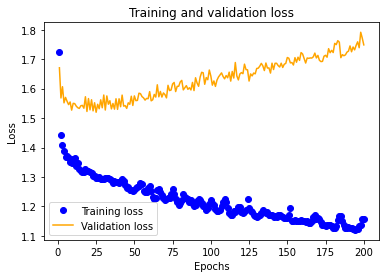

In [65]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

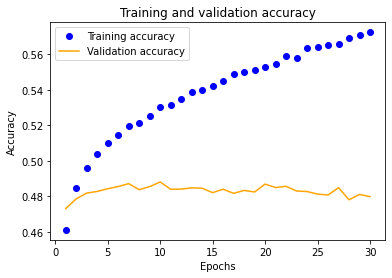

In [49]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig('accuracy.png')
plt.show()

In [50]:
X_test.shape

(62820, 273)

In [51]:
y_test.shape

(62820, 1)

In [36]:
preds = model.predict(X_test) 
predictionsFiles =np.argmax(preds, axis=1)

1562/1562 [==============================] - 3s 2ms/step


(array([ 5859.,     0.,     0.,     0.,     0., 23918.,     0.,     0.,
            0., 20201.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

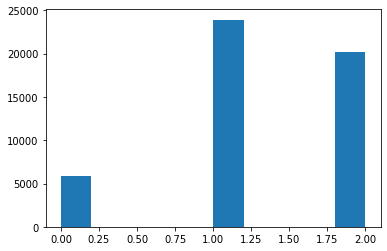

In [37]:
plt.hist(predictionsFiles)

In [38]:
#pd.DataFrame(predictionsFiles).to_csv("predictionsFiles.csv",header='predict', index=False)

In [39]:
#pd.DataFrame(y_test).to_csv("true.csv",header='true', index=False)

In [40]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6537553668022156
Test accuracy: 0.7426868081092834


Confusion matrix:
[[ 4409  2335  1904]
 [  727 17153  2741]
 [  723  4430 15556]]


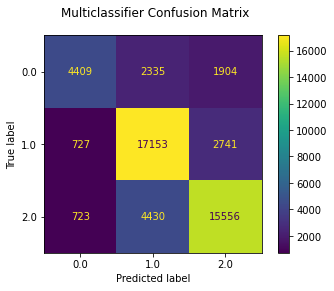

In [41]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('confusionMatrix.png')
plt.show()

In [66]:
preds_huge = model.predict(X_test_huge) 
predictionsFiles_huge =np.argmax(preds_huge, axis=1)

29672/29672 [==============================] - 52s 2ms/step


Confusion matrix:
[[ 84246  44037  37330]
 [ 13753 324394  53399]
 [ 13334  84451 294551]]


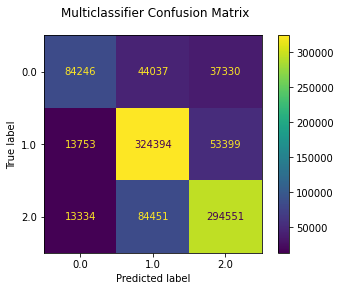

In [67]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test_huge, predictionsFiles_huge)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('confusionMatrix.png')
plt.show()

In [50]:
from sklearn.metrics import RocCurveDisplay

In [51]:
from sklearn.preprocessing import LabelBinarizer

In [53]:
def ROC_OvR(preds, labels):
    classes = np.unique(labels)
    n_classes = len(classes)

    #go through each class to build a one-versus-rest ROC
    scores = []
    truth = []

    for c in range(1, n_classes):
        in_class = 1.0 *(labels == c)
        score = preds[:,c]

        scores.append(score)
        truth.append(in_class)

    scores = np.array(scores).ravel()
    truth = np.array(truth).ravel()

    return truth, scores


In [62]:
t, s = ROC_OvR(preds, y_test)

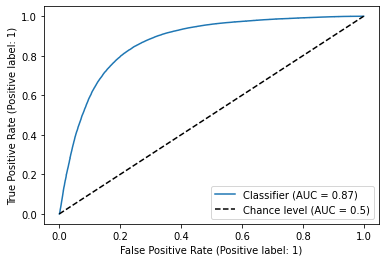

In [63]:
RocCurveDisplay.from_predictions(
    t,
    s,
    plot_chance_level=True
)

In [68]:
t2, s2 = ROC_OvR(preds_huge, y_test_huge)

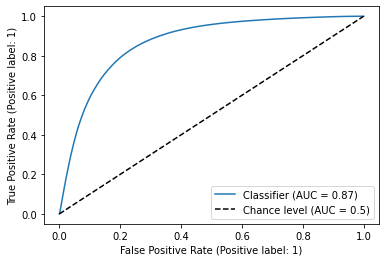

In [69]:
RocCurveDisplay.from_predictions(
    t2,
    s2,
    plot_chance_level=True
)

In [110]:
#model.save('my_model.keras')

In [111]:
#model.save('my_model.h5')

In [22]:
#loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
#print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

112434/112434 - 87s - loss: 0.5151 - sparse_categorical_accuracy: 0.7878 - 87s/epoch - 778us/step
Restored model, accuracy: 78.78%
